Semantics: meaning of words & sentences

Use unsupervised neural network on a corpus of texts to learn the rules of a language by identifying recurring patterns within the corpus. Can then use the trained unsupervised model to understand new sentences. 

Document frequency: counts how many sentences a word appears in

Collection frequency: counts how often a word appears, total, over all sentences

Latent Semantic Analysis

Reduce tf-idf-weighted term-document matrix (term frequency (how frequently a term appears within a sentence) - inverse document frequency (weight the document frequency, words that occur less often are more influential than words that occur a lot) into a lower-dimensional space

Principal Component Analysis (PCA)

In [5]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import gutenberg
import re
from sklearn.model_selection import train_test_split

In [6]:
# read in data in the form of paragraphs
emma = gutenberg.paras('austen-emma.txt')

In [9]:
display(emma)

[[['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']']], [['VOLUME', 'I']], ...]

In [10]:
emma_paras = []
for paragraph in emma:
    para = paragraph[0]
    # removing the double-dash from all words
    para = [re.sub(r'--','',word) for word in para]
    # forming each paragraph into a string and adding it to the list of strings
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [11]:
# use sklearn TfidfVectorizer to create matrix
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras,test_size=0.4,random_state=0)

In [12]:
vectorizer = TfidfVectorizer(max_df=0.5, #drop words that occure in more than half the paragraphs
                             min_df=2, #only use words that appear at least twice
                             stop_words='english',
                             lowercase=True, #convert everything to lowercase
                             use_idf=True, #we definitely want to use inverse document frequencies in weighting
                             norm=u'l2', #applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #adds 1 to all document frequencies, as if an extra document existed that used every word once. Prevents divide-by-zero errors
                            )

In [13]:
# applying the vectorizer
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

Number of features: 1948


In [14]:
# splitting into training and test sets
X_train_tfidf,X_test_tfidf = train_test_split(emma_paras_tfidf,test_size=0.4,random_state=0)

In [15]:
# reshape vecortizer output into readable format
X_train_tfidf_csr = X_train_tfidf.tocsr()

In [16]:
# number of paragraphs
n = X_train_tfidf_csr.shape[0]

In [17]:
# a list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

In [18]:
# a list of features
terms = vectorizer.get_feature_names()

In [19]:
# for each paragraph, lists the feature words and their tf-idf scores
for i,j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i,j]

In [20]:
# tf-idf score of 0 indicates that the word is present once in that sentence (log base 2 of 1 is 0)
print('Original sentence: ',X_train[5])
print('Tf_idf vector: ',tfidf_bypara[5])

Original sentence:  A very few minutes more , however , completed the present trial .
Tf_idf vector:  {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


## Dimension Reduction

In [21]:
# use singular value decomposition (SVD) b/c we don't want to mean-center variables (lose sparsity)
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# SVD data reducer (reduce feature space from 1379 to 130)
svd = TruncatedSVD(130)
lsa = make_pipeline(svd,Normalizer(copy=False))

In [23]:
# run SVD on the training data, then project the training data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: ",total_variance*100)

Percent variance captured by all components:  45.19123972886386


In [25]:
# Looking at which paragraphs our solution consider similar for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print("Component {}:".format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !     0.999291
" Oh !     0.999291
" Oh !"    0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.633942
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.589437
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.564911
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.564108
" There were misunderstand

## Sentence similarity

In [26]:
# compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa)*np.asmatrix(X_train_lsa).T)

In [27]:
# only take first 10 sentences
sim_matrix = pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]

In [28]:
# make a plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

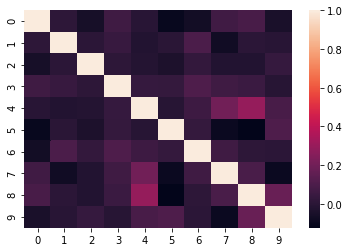

In [29]:
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

In [30]:
# generating a key for the plot
print("Key: ")
for i in range(10):
    print(i,sim_matrix.index[i])

Key: 
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on bein

Not much similarity between the first 10 sentences...

## Drill 0 (Test set)
Apply LSA model to the test set (does it identify similar sentences for components 0 through 4?)

In [31]:
X_test_tfidf_csr = X_test_tfidf.tocsr()

In [32]:
n = X_test_tfidf_csr.shape[0]

In [33]:
tfidf_bypara_test = [{} for _ in range(0,n)]

In [35]:
for i,j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara_test[i][terms[j]] = X_test_tfidf_csr[i,j]

In [36]:
print('Original sentence: ',X_test[5])
print('Tf_idf vector: ',tfidf_bypara_test[5])

Original sentence:  " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
Tf_idf vector:  {'resolving': 0.3424390305045805, 'unexceptionable': 0.3196409792117937, 'assure': 0.267729777836069, 'friends': 0.2515333740641343, 'quite': 0.1916471918420347, 'replied': 0.20315405638674577, 'watch': 0.62300800500314, 'elton': 0.16874782424809767, 'pass': 0.28445227585106625, 'really': 0.21963852817625326, 'mrs': 0.14780961753993585}


In [38]:
X_test_lsa = lsa.transform(X_test_tfidf)

In [39]:
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print("Component {}:".format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !     0.999291
" Oh !     0.999291
" Oh !"    0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                                                                                          0.675741
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbation of  and it then appeared that Mrs . Weston was wanting _him_ to dance with Mrs . Elton him

## Drill 1 Tweaking tf-idf

In [40]:
vectorizer = TfidfVectorizer(max_df=0.3, #drop words that occur in more than half the paragraphs
                             min_df=3, #only use words that appear at least twice
                             stop_words='english',
                             lowercase=True, #convert everything to lowercase
                             use_idf=True, #we definitely want to use inverse document frequencies in weighting
                             norm=u'l2', #applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #adds 1 to all document frequencies, as if an extra document existed that used every word once. Prevents divide-by-zero errors
                            )

In [42]:
emma_paras_tfidf2 = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

Number of features: 1358


In [41]:
svd = TruncatedSVD(130)
lsa = make_pipeline(svd,Normalizer(copy=False))

In [43]:
X_train_tfidf,X_test_tfidf = train_test_split(emma_paras_tfidf2,test_size=0.4,random_state=0)

In [44]:
X_train_tfidf_csr = X_train_tfidf.tocsr()

In [45]:
n = X_train_tfidf_csr.shape[0]

In [46]:
tfidf_bypara = [{} for _ in range(0,n)]

In [47]:
terms = vectorizer.get_feature_names()

In [48]:
for i,j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i,j]

In [49]:
print('Original sentence: ',X_train[5])
print('Tf_idf vector: ',tfidf_bypara[5])

Original sentence:  A very few minutes more , however , completed the present trial .
Tf_idf vector:  {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [50]:
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: ",total_variance*100)

Percent variance captured by all components:  48.42094388088548


In [51]:
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print("Component {}:".format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !    0.999237
" Oh !    0.999237
" Oh !    0.999237
Oh !      0.999237
" Oh !    0.999237
" Oh !    0.999237
" Oh !    0.999237
" Oh !    0.999237
" Oh !    0.999237
" Oh !    0.999237
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.676696
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.597394
" There were misunderstandings between them , Emma ; he said so expressly .                                                                                                 0.595017
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.573618
" I do not admire it ," said Mr . Kn

By decreasing the range of values in the vector we were able to increase the variance explained by the model by a slight percentage (45.19 --> 48.42). 